In [116]:
import os
import cv2
import json
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
from transformers import ViTImageProcessor, TFViTModel
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


%matplotlib inline

In [2]:
folder = "csce566_project_data"
flist = os.listdir(folder)

print(flist)

['test', 'train', 'val']


In [3]:
ftrain = os.path.join(folder, "train")
ftest = os.path.join(folder, "test")
fval = os.path.join(folder, "val")

def load_file(folder, idx):
    file = np.load(os.path.join(folder, os.listdir(folder)[idx]))
    return file

sample_data = load_file(ftrain, 0)
print("Data Features: ",sample_data.files, "\n")

print("Length of training set: ", len(os.listdir(ftrain)), "records")
print("Length of validation set: ", len(os.listdir(fval)), "records")
print("Length of testing set: ", len(os.listdir(ftest)), "records")

Data Features:  ['slo_fundus', 'race', 'male', 'hispanic', 'maritalstatus', 'language', 'dr_class', 'dr_subtype'] 

Length of training set:  4476 records
Length of validation set:  641 records
Length of testing set:  1914 records


# Exploratory Data Analysis

Unique RACE values: [0 1 2]
Unique MALE values: [0 1]
Unique HISPANIC values: [0 1]
Unique MARITALSTATUS values: [0 1 2 3 4]
Unique LANGUAGE values: [0 1 2]
Unique DR_CLASS values: [0 1]
Unique DR_SUBTYPE values: ['no.dr.diagnosis' 'pdr']

'slo_fundus' Image Shape:  (200, 200, 3)


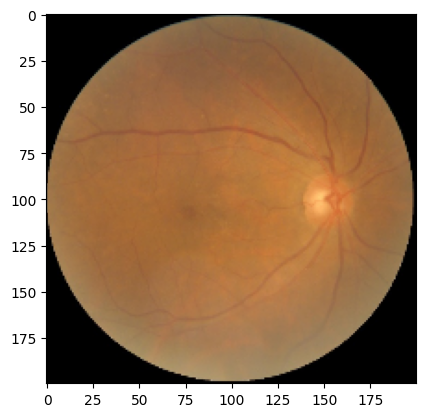

In [7]:
attr_dict = {attr: [] for attr in sample_data.files}

# Function to process a directory
def process_directory(folder):
    for idx in range(len(os.listdir(folder))):
        data = load_file(folder, idx)
        for attr in attr_dict.keys():
            attr_dict[attr].append(data[attr])

# Process all directories
for folder in [ftrain, fval, ftest]:
    process_directory(folder)

for attr in attr_dict.keys():
    if attr != 'slo_fundus':
        print(f"Unique {attr.upper()} values:", np.unique(attr_dict[attr]))

print("\n'slo_fundus' Image Shape: ", sample_data['slo_fundus'].shape)
plt.imshow(sample_data['slo_fundus'][..., ::-1])
plt.show()


### Check Data Distribution

Positive Cases: 1791  / Negative Cases: 5240
Males: 3771  / Females: 3260


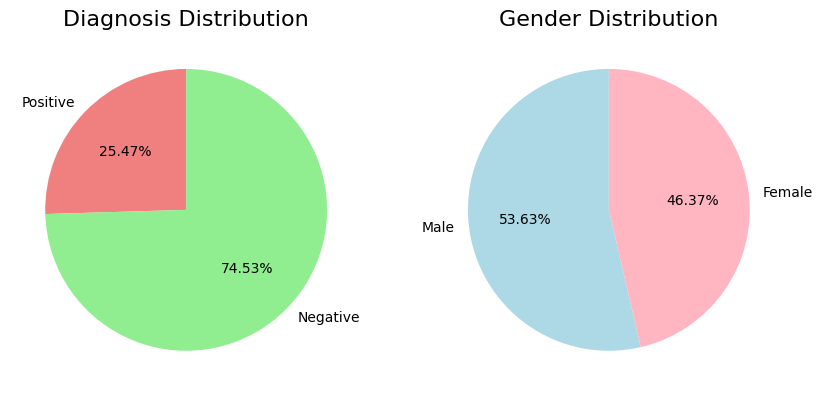

In [5]:
# Check the diagnosis distribution in the training data
positive_count = sum(attr_dict['dr_class'])
negative_count = len(attr_dict['dr_class']) - positive_count
label_counts = [positive_count, negative_count]
print("Positive Cases:", positive_count, " / Negative Cases:", negative_count)

# Check the gender distribution in the training data
male_count = sum(attr_dict['male'])
female_count = len(attr_dict['male']) - male_count
gender_counts = [male_count, female_count]
print("Males:", male_count, " / Females:", female_count)

# Visualize the diagnosis and gender distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pie(label_counts, labels=['Positive', 'Negative'], autopct='%1.2f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
ax[0].set_title('Diagnosis Distribution', fontsize=16)
ax[1].pie(gender_counts, labels=['Male', 'Female'], autopct='%1.2f%%', startangle=90, colors=['lightblue', 'lightpink'])
ax[1].set_title('Gender Distribution', fontsize=16)

plt.show()

##### The gender of the sample patients seem to be roughly balanced with about 7% more males than females. The diagnosis distribution is very imbalanced however, which may make modeling of the data more challenging.
#

### Check Image and Label consistency

In [8]:
# Check that dr_subtype class is redundant with dr_class
for i, label in enumerate(attr_dict['dr_class']):
    if label == 1 and attr_dict['dr_subtype'][i] != 'pdr':
        print("Mismatched Label: ", i)
else:
    print("'dr_subtype' is a redundant feature:\n'dr_class': 1 == 'dr_subtype': PDR (proliferative diabetic retinopathy)")

# Check for consisten image shapes
print("\nChecking image shapes in each folder...")
for folder in [ftrain, fval, ftest]:
    folder_name = folder.split("\\")[-1].upper()
    for idx in range(len(os.listdir(folder))):
        data = load_file(folder, idx)
        if data['slo_fundus'].shape != (200, 200, 3):
            print(f"Image shape mismatch in {folder_name} DATA at index {idx}: {data['slo_fundus'].shape}")
    print(f"Image shapes in {folder_name} DATA are consistent: {data['slo_fundus'].shape}")

'dr_subtype' is a redundant feature:
'dr_class': 1 == 'dr_subtype': PDR (proliferative diabetic retinopathy)

Checking image shapes in each folder...
Image shapes in TRAIN DATA are consistent: (200, 200, 3)
Image shapes in VAL DATA are consistent: (200, 200, 3)
Image shapes in TEST DATA are consistent: (200, 200, 3)


### Compare POSITIVE vs. NEGATIVE diagnosis images

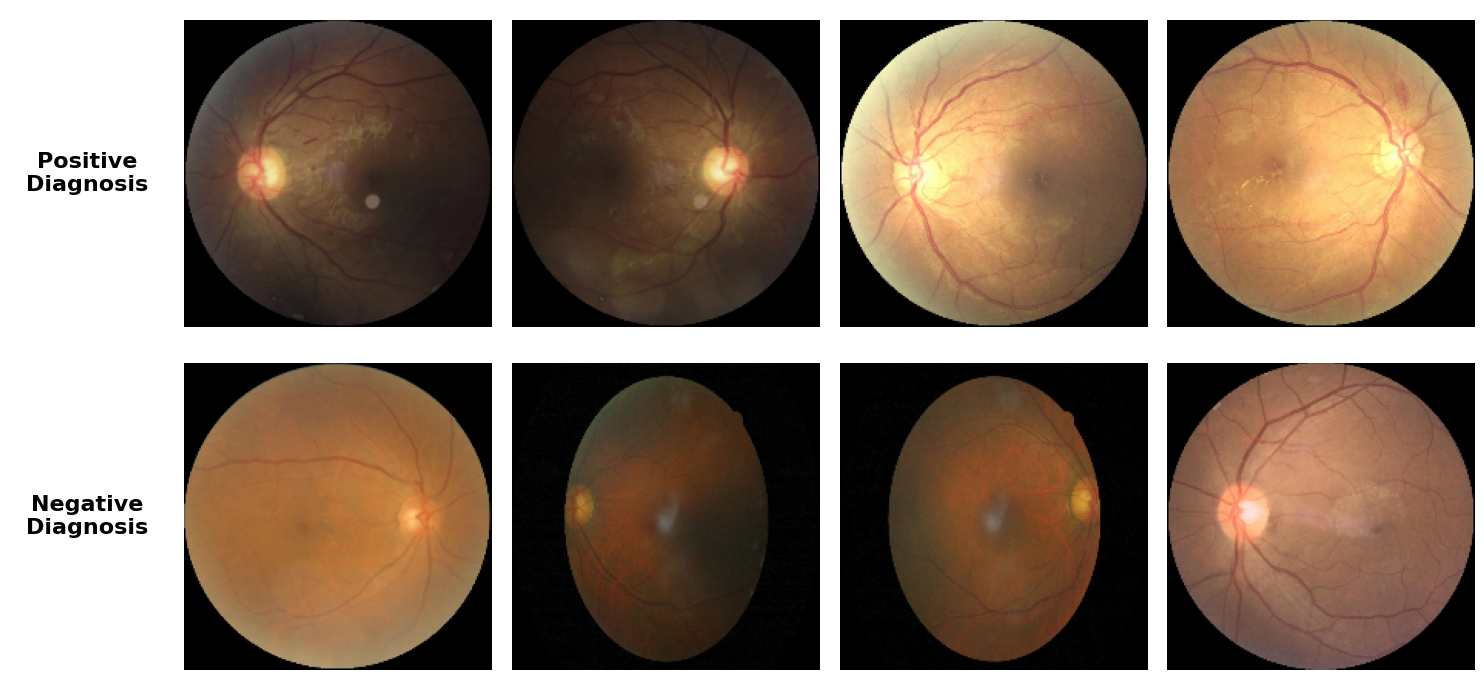

In [9]:
positive_indices = [i for i, label in enumerate(attr_dict['dr_class']) if label == 1]
negative_indices = [i for i, label in enumerate(attr_dict['dr_class']) if label == 0]

positive_images = [load_file(ftrain, i)['slo_fundus'] for i in positive_indices[:4]]
negative_images = [load_file(ftrain, i)['slo_fundus'] for i in negative_indices[:4]]

fig, ax = plt.subplots(2, 5, figsize=(15, 7), gridspec_kw={'width_ratios': [0.5, 1, 1, 1, 1]})
ax[0, 0].text(0.5, 0.5, 'Positive\nDiagnosis', horizontalalignment='center', verticalalignment='center', fontsize=16, fontweight='bold')
ax[0, 0].axis('off')
ax[1, 0].text(0.5, 0.5, 'Negative\nDiagnosis', horizontalalignment='center', verticalalignment='center', fontsize=16, fontweight='bold')
ax[1, 0].axis('off')

for i in range(4):
    ax[0, i+1].imshow(positive_images[i][..., ::-1])
    ax[0, i+1].axis('off')
    ax[1, i+1].imshow(negative_images[i][..., ::-1])
    ax[1, i+1].axis('off')

plt.tight_layout()
plt.show()


##### The images above show inconsistency in the lighting conditions, zoom, and angle of the retina scans, which can limit the ability of a NN models to identify generalizable features. Adding additional contrast to the images can help features stand out, especially on darker images. During a literature review of related work, techniques like Gaussian filters and Contrast Limited Adaptive Histogram Equalization (CLAHE) were identified to effectively enhance the details of the images and to mitigate some of the lighting inconsistencies. Cropping was also used to mitigate some of the inconsistences in zoom and angle that resulted in extra space around the circular fundus.
#

In [10]:
def augment_image(image):
    if random.random() < 0.5:
        image = cv2.flip(image, 1)

    angle = random.uniform(-90, 90)
    center = (image.shape[1] / 2, image.shape[0] / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

    return image


def remove_extra_space(img, resize_dim, tol=7):
    # Mask pixels values with values over the tolerance level (tol)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray_img > tol
    
    # Check if the image is too dark to crop
    check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
    if check_shape == 0:
        return img
    else:
        img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
        img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
        img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
        img = np.stack([img1, img2, img3], axis=-1)

    img = cv2.resize(img, (resize_dim, resize_dim), interpolation=cv2.INTER_AREA)

    return img


def circle_crop(img, resize_dim=224):
    img = remove_extra_space(img, resize_dim)

    # Get the center and radius of the image
    height, width, _ = img.shape    
    x = int(width / 2)
    y = int(height / 2)
    r = min(x, y)

    # Crop using the circular mask
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    
    img = remove_extra_space(img, resize_dim)

    return img


def apply_clahe(img, clip=2.5, gauss_color_filter=False, resize_dim=224):
    # Convert the image from RGB to LAB color space
    img = circle_crop(img, resize_dim)
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(img_lab)

    # Create CLAHE filter and apply it to each channel
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)
    ca = clahe.apply(a_channel)
    cb = clahe.apply(b_channel)

    # Merge the CLAHE enhanced channels and convert back to RGB
    merged_lab = cv2.merge((cl, ca, cb))
    enhanced_img = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2RGB)

    if gauss_color_filter:
        enhanced_img = cv2.addWeighted(enhanced_img, 4, cv2.GaussianBlur(enhanced_img, (0, 0), enhanced_img.shape[0] / 30), -4, 128)
        enhanced_img = circle_crop(enhanced_img, resize_dim)

    return enhanced_img


### Data Preprocessing

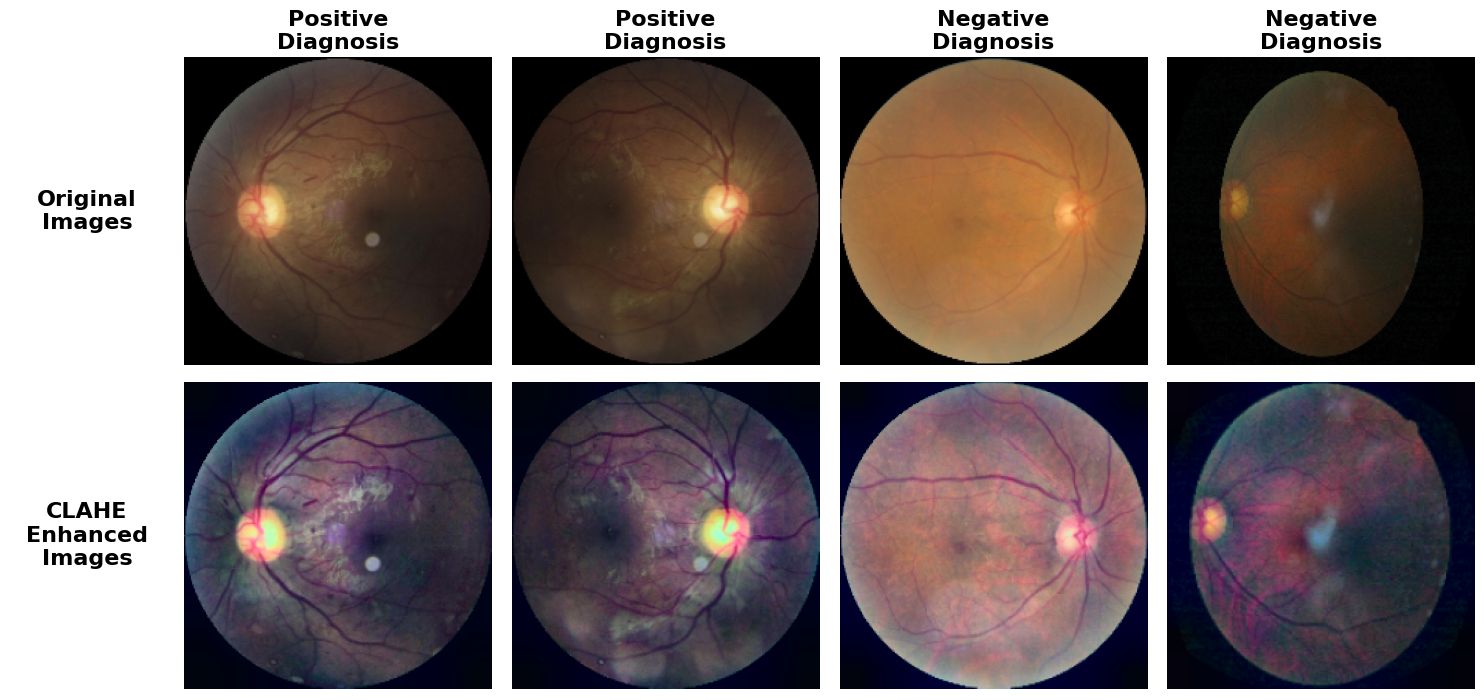

In [11]:
clahe_positive_images = [apply_clahe(img, 2.5) for img in positive_images]
clahe_negative_images = [apply_clahe(img, 2.5) for img in negative_images]

fig, ax = plt.subplots(2, 5, figsize=(15, 7), gridspec_kw={'width_ratios': [0.5, 1, 1, 1, 1]})
ax[0, 0].text(0.5, 0.5, 'Original\nImages', horizontalalignment='center', verticalalignment='center', fontsize=16, fontweight='bold')
ax[0, 0].axis('off')
ax[1, 0].text(0.5, 0.5, 'CLAHE\nEnhanced\nImages', horizontalalignment='center', verticalalignment='center', fontsize=16, fontweight='bold')
ax[1, 0].axis('off')

for i in range(2):
    ax[0, i+1].imshow(positive_images[i][..., ::-1])
    ax[0, i+1].set_title('Positive\nDiagnosis', fontsize=16, fontweight='bold')
    ax[0, i+1].axis('off')
    ax[0, i+3].imshow(negative_images[i][..., ::-1])
    ax[0, i+3].set_title('Negative\nDiagnosis', fontsize=16, fontweight='bold')
    ax[0, i+3].axis('off')
    ax[1, i+1].imshow(clahe_positive_images[i][..., ::-1])
    ax[1, i+1].axis('off')
    ax[1, i+3].imshow(clahe_negative_images[i][..., ::-1])
    ax[1, i+3].axis('off')

plt.tight_layout()
plt.show()

##### Cropping and applying a CLAHE filter to the color fundus images does seem to make the vasculature and other features more defined, so it was used for preprocessing the images within the datagenerator below.
#

Using Vision Transformer (ViT) Model:
Generator Batch Shape:  (10, 3, 224, 224)
Sample Range of RGB Values:  [-0.96862745, 1.0]


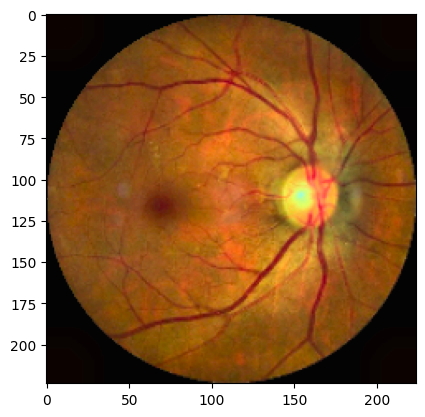

Using Convolutional Neural Network (CNN) Model:
Generator Batch Shape:  (10, 224, 224, 3)
Sample Range of RGB Values:  [4.0, 244.0]


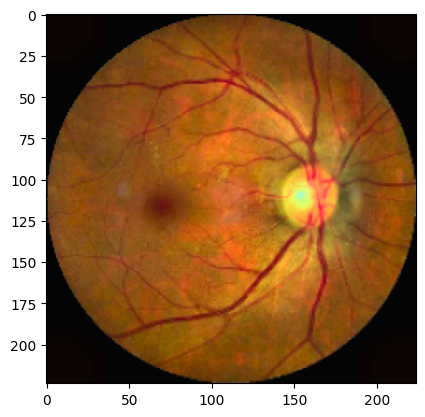

In [115]:
image_processor = ViTImageProcessor()

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, folder, shape, batch_size=8, shuffle=False, clahe=False, augment=False, gfilter=False, use_vit=False, **kwargs):
        super().__init__(**kwargs)
        self.folder = folder
        self.shape = shape
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.clahe = clahe
        self.augment = augment
        self.gfilter = gfilter
        self.use_vit = use_vit
        self.flist = os.listdir(folder)
        self.indexes = np.arange(len(self.flist))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.flist) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.flist[i] for i in batch_indexes]
        X, y = self.__data_generation(batch_files)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_files):
        X = np.empty((self.batch_size, *self.shape), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.int32)
        
        for i, f in enumerate(batch_files):
            data = np.load(os.path.join(self.folder, f))
            image = data['slo_fundus'][..., ::-1]
            image = augment_image(image) if self.augment else image
            image = apply_clahe(image, gauss_color_filter=self.gfilter) if self.clahe else cv2.resize(image, (self.shape[0], self.shape[1]), interpolation=cv2.INTER_AREA)
            image = cv2.resize(image, (self.shape[0], self.shape[1]), interpolation=cv2.INTER_AREA)
            X[i,] = image
            y[i] = data['dr_class']
        
        if self.use_vit:
            X = image_processor(X, return_tensors="tf")['pixel_values']
        
        return X, y
    
batch_size = 10
train_generator = DataGenerator(ftrain, shape=(224, 224, 3), batch_size=batch_size, shuffle=True, clahe=True, use_vit=True)
validation_generator = DataGenerator(fval, shape=(224, 224, 3), batch_size=batch_size, clahe=True)
test_generator = DataGenerator(ftest, shape=(224, 224, 3), batch_size=batch_size, clahe=True)

sample = train_generator.__getitem__(0)[0]
print("Using Vision Transformer (ViT) Model:")
print("Generator Batch Shape: ", sample.shape)
print("Sample Range of RGB Values: ", [tf.reduce_min(sample[0, 0, 100]).numpy(), tf.reduce_max(sample[0, 0, 100]).numpy()])
image = (sample[0] + 1) / 2  # Convert to [0, 1] range
plt.imshow(tf.transpose(image, perm=[1, 2, 0]))
plt.show()

train_generator.use_vit = False
sample = train_generator.__getitem__(0)[0]
print("Using Convolutional Neural Network (CNN) Model:")
print("Generator Batch Shape: ", sample.shape)
print("Sample Range of RGB Values: ", [min(sample[0, :, 100, 0]), max(sample[0, :, 100, 0])])
image = (sample[0]) / 255.0  # Convert to [0, 1] range
plt.imshow(image)
plt.show()

### Check label distribution across all datasets

Positive label occurance in Train Data: 25.01%  (Batch Count: 447  /  Record Count: 4470  /  Unique Label Values: [0 1])
Positive label occurance in Val Data: 28.44%  (Batch Count: 64  /  Record Count: 640  /  Unique Label Values: [0 1])
Positive label occurance in Test Data: 25.65%  (Batch Count: 191  /  Record Count: 1910  /  Unique Label Values: [0 1])


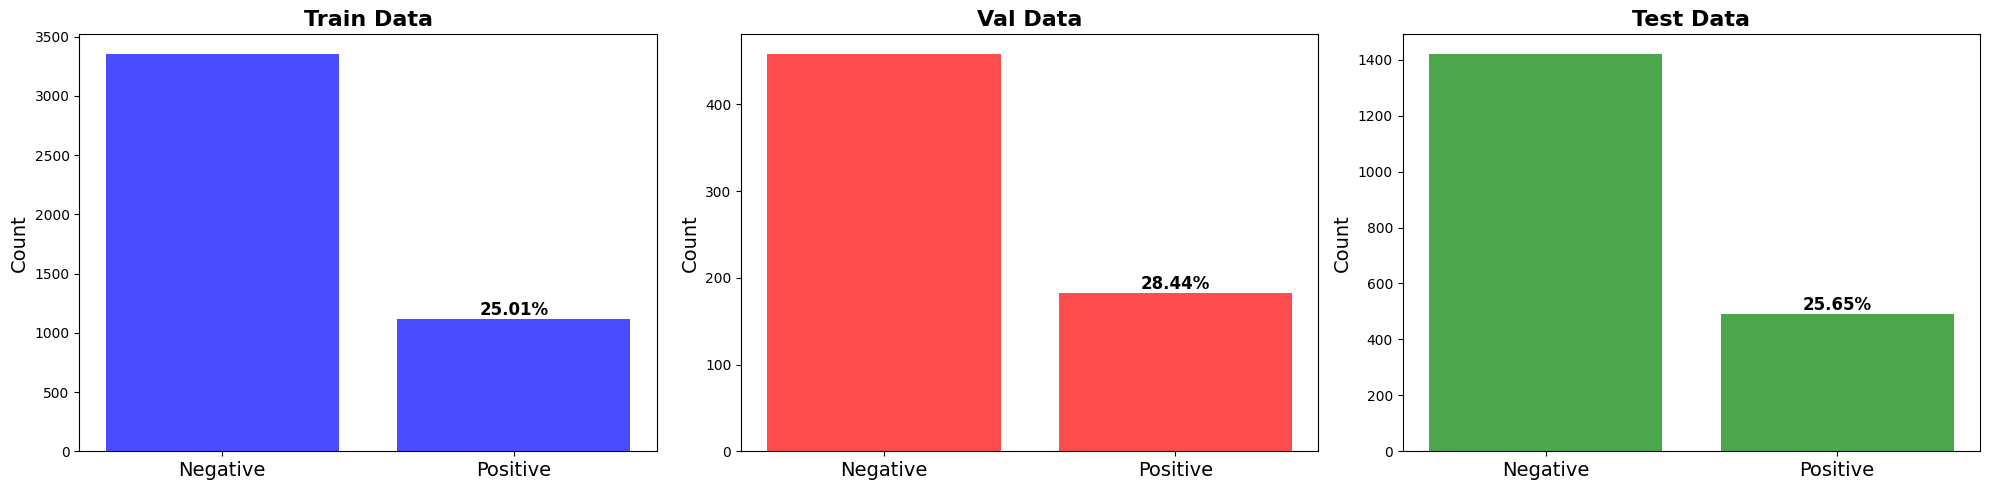

In [17]:
# Check label distribution across datasets
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
color = ['blue', 'red', 'green']

for i, generator in enumerate([train_generator, validation_generator, test_generator]):
    label_data = []
    for j in range(generator.__len__()):
        _, labels = generator.__getitem__(j)
        label_data.extend(labels)
    
    values, counts = np.unique(label_data, return_counts=True)
    positive_percentage = round((sum(label_data)/len(label_data)) * 100, 2)
    data_name = generator.folder.split('\\')[-1].capitalize()

    print(f"Positive label occurance in {data_name} Data: {positive_percentage}%  (Batch Count: {generator.__len__()}  /  Record Count: {len(label_data)}  /  Unique Label Values: {values})")

    ax[i].bar(values, counts, color=color[i], alpha=0.7)
    ax[i].set_title(f"{data_name} Data", fontsize=16, fontweight='bold')
    ax[i].set_ylabel("Count", fontsize=14)
    ax[i].set_xticks(values)
    ax[i].set_xticklabels(['Negative', 'Positive'], fontsize=14)
    ax[i].text(values[1], counts[1], f'{positive_percentage}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Check for data leakage between datasets

In [19]:
def check_overlap(generator1, generator2, name1, name2):
    print(f"Checking overlap between {name1.upper()} and {name2.upper()} datasets...")
    overlap_count = 0
    images1_set = set()
    
    for i in range(len(generator1)):
        images1, _ = generator1.__getitem__(i)
        for img1 in images1:
            images1_set.add(img1.tobytes())
    
    for j in range(len(generator2)):
        images2, _ = generator2.__getitem__(j)
        for img2 in images2:
            if img2.tobytes() in images1_set:
                overlap_count += 1
    
    print(f"Overlap between {name1.upper()} and {name2.upper()}: {overlap_count} images")

train_generator.augment = False
check_overlap(test_generator, train_generator, "Test", "Training")
check_overlap(validation_generator, train_generator, "Validation", "Training")
check_overlap(validation_generator, test_generator, "Validation", "Test")
train_generator.augment = True

Checking overlap between TEST and TRAINING datasets...
Overlap between TEST and TRAINING: 0 images
Checking overlap between VALIDATION and TRAINING datasets...
Overlap between VALIDATION and TRAINING: 0 images
Checking overlap between VALIDATION and TEST datasets...
Overlap between VALIDATION and TEST: 640 images


##### It seems that almost all of the images from the validation set are also contained within the test set. Ideally, these two datasets would be exclusive from one another to better assess the generalizability of the model. Since neither set has any overlap with the training images, however, it will not cause any issues with the training process directly.
#

## CNN Model Training

In [20]:
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(attr_dict['dr_class']),
    y = np.array(attr_dict['dr_class'])
)

class_weights = {0 : class_weights[0], 1 : class_weights[1]}
print ("Class weights: ", class_weights)

Class weights:  {0: 0.6708969465648855, 1: 1.9628699050809604}


##### The EfficentNet architecture below is based on the specifications outlined in the EfficientNet documentation. Per the original EfficientNet paper, the classification head should be pre-trained for several epochs before unfreezing the EfficientNet layers (BatchNormalization layers should remain frozen during fine-tuning too though.)

In [ ]:
def build_model_efficient(img_size=300, channel=3, num_classes=1, dropout=0.5, additional_layer=None, classifier_activation='sigmoid'):
    input_shape=(img_size, img_size, channel)
    img = tf.keras.layers.Input(shape=input_shape)
    
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_tensor=img,
        pooling=None
    )
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    if additional_layer != None:
        x = tf.keras.layers.Dense(additional_layer, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout)(x)

    output_layer = tf.keras.layers.Dense(num_classes, activation=classifier_activation)(x)

    model = tf.keras.models.Model(inputs=img, outputs=output_layer)
    
    return model

def unfreeze_model(model, trainable_layers='All'):
    if trainable_layers == 'All':
        for layer in model.layers:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True
    else:
        for layer in model.layers[-trainable_layers:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True


In [ ]:
PARAMS = {
    'trainable_layers': 'All', # 340 total layers in B1 / 31 = start of block 7
    'dropout': 0.5,
    'additional_classifier_layer': None,
    'classifier_activation': 'sigmoid',
    'learning_rate': 1e-5,
    'batch_size': 10,
    'use_clahe': True,
    'gauss_filter': False,
    'minority_weight': None
}

cnn_model = build_model_efficient(
    dropout = PARAMS['dropout'],
    additional_layer=PARAMS['additional_classifier_layer'],
    classifier_activation = PARAMS['classifier_activation']
)

cnn_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = 'binary_crossentropy',
    metrics = ['acc', 'AUC']
)

cnn_model.summary()

train_generator = DataGenerator(ftrain, shape=(300, 300, 3), batch_size=PARAMS['batch_size'], clahe=PARAMS['use_clahe'], gfilter=PARAMS['gauss_filter'], shuffle=True, augment=True)
validation_generator = DataGenerator(fval, shape=(300, 300, 3), batch_size=PARAMS['batch_size'], clahe=PARAMS['use_clahe'])
test_generator = DataGenerator(ftest, shape=(300, 300, 3), batch_size=PARAMS['batch_size'], clahe=PARAMS['use_clahe'])

print("Pre-training the classificaiton head...")
history = cnn_model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = len(train_generator),
    epochs = 8,
    verbose = 1,
    class_weight = None if PARAMS['minority_weight'] == None else {0: 1, 1: PARAMS['minority_weight']},
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ]
)

unfreeze_model(cnn_model, trainable_layers=PARAMS['trainable_layers'])
print("Layers unlocked for training: ", len(cnn_model.trainable_variables))

cnn_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=PARAMS['learning_rate']),
    loss = 'binary_crossentropy',
    metrics = ['acc', 'AUC']
)

print("Fine-tuning the model...")
history2 = cnn_model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = len(train_generator),
    epochs = 30,
    verbose = 1,
    class_weight = None if PARAMS['minority_weight'] == None else {0: 1, 1: PARAMS['minority_weight']},
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7)]
)

for key in history.history.keys():
    history.history[key].extend(history2.history[key])


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization_4 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 tf.math.multiply_4 (TFOpLa  (None, 224, 224, 3)          0         ['normalization_4[0][0]'

In [54]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'auc', 'val_loss', 'val_acc', 'val_auc'])


In [65]:
def plot_model_history(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    auc = history['auc']
    val_auc = history['val_auc']

    plt.figure(figsize=(14, 10))
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training and validation auc
    plt.subplot(2, 2, 3)
    plt.plot(epochs, auc, 'bo-', label='Training AUC')
    plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
    plt.title('Training and validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Model Results:
Best Validation Accuracy:  0.79
Lowest Validation Loss:  0.48 

Train Accuracy:  0.82  / Train AUC:  0.84  / Train Loss:  0.41
Validation Accuracy:  0.78  / Validation AUC:  0.79  / Validation Loss:  0.49


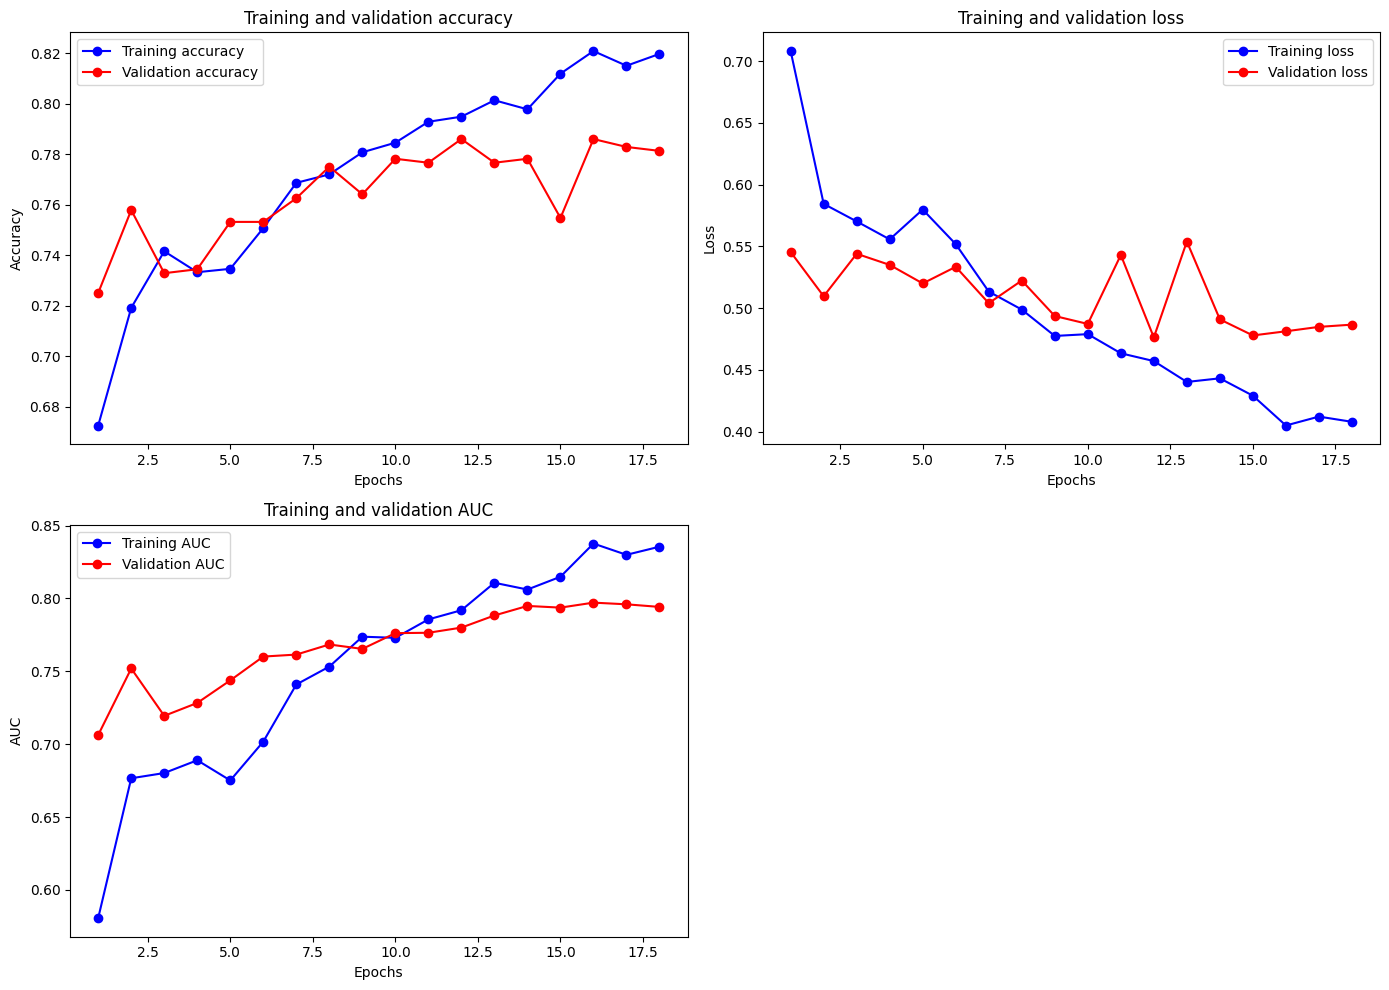

In [77]:
print("Model Results:")
print("Best Validation Accuracy: ", round(max(history.history['val_acc']), 2))
print("Lowest Validation Loss: ", round(min(history.history['val_loss']), 2), "\n")
print("Train Accuracy: ", round(history.history['acc'][-1], 2), " / Train AUC: ", round(history.history['auc'][-1], 2), " / Train Loss: ", round(history.history['loss'][-1], 2))
print("Validation Accuracy: ", round(history.history['val_acc'][-1], 2), " / Validation AUC: ", round(history.history['val_auc'][-1], 2), " / Validation Loss: ", round(history.history['val_loss'][-1], 2))
plot_model_history(history.history)

In [ ]:
### GRID SEARCH ###

def convert_history(history):
    converted_history = {}
    for key, values in history.items():
        if isinstance(values, list):
            converted_history[key] = [float(v) if isinstance(v, (np.float32, np.float64)) else v for v in values]
        else:
            converted_history[key] = float(values) if isinstance(values, (np.float32, np.float64)) else values
    return converted_history

params = {
    'minority_class_weights': [0],
    'clahe': [True],
    'gaussian_filter': [False],
    'trainable_layers': [5, 10, 15],
    'additional_layer': [256, 512],
    'dropout': [0.3, 0.5],
    'learning_rate': [0.00001]
}

ops_count = np.prod([len(v) for v in params.values()])
print(f"Total Model Iterations to Test: {ops_count}")

idx = 0
for minority_class_weights in params['minority_class_weights']:
    for clahe in params['clahe']:
        for gaussian_filter in params['gaussian_filter']:
            for trainable_layers in params['trainable_layers']:
                for additional_layer in params['additional_layer']:
                    for dropout in params['dropout']:
                        for learning_rate in params['learning_rate']:
                            idx += 1
                            iter_params = {
                                'minority_class_weights': minority_class_weights,
                                'clahe': clahe,
                                'gaussian_filter': gaussian_filter,
                                'trainable_layers': trainable_layers,
                                'additional_layer': additional_layer,
                                'dropout': dropout,
                                'learning_rate': learning_rate
                            }
                            
                            print(f"\nIteration {idx}")
                            print(iter_params, "\n")

                            train_generator = DataGenerator(ftrain, shape=(224, 224, 3), batch_size=batch_size, shuffle=True, clahe=clahe, gfilter=gaussian_filter, augment=True, use_vit=False)
                            validation_generator = DataGenerator(fval, shape=(224, 224, 3), batch_size=batch_size, shuffle=False, clahe=clahe)
                            test_generator = DataGenerator(ftest, shape=(224, 224, 3), batch_size=batch_size, shuffle=False, clahe=clahe)

                            model = build_model_efficient(
                                additional_layer=additional_layer,
                                dropout=dropout
                            )

                            if trainable_layers != 'All':
                                unfreeze_model(model, trainable_layers=trainable_layers)

                            model.compile(
                                optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                                loss = 'binary_crossentropy',
                                metrics = ['acc', 'AUC']
                            )

                            if minority_class_weights == 0:
                                cw = None
                            else:
                                cw = {0: 1.0, 1: minority_class_weights}
                            
                            history = model.fit(
                                train_generator,
                                validation_data = validation_generator,
                                steps_per_epoch = len(test_generator),
                                epochs = 80,
                                class_weight = cw,
                                callbacks = [
                                    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=8, min_lr=1e7)
                                ]
                            )

                            result = {
                                'iteration': idx,
                                'params': iter_params,
                                'history': convert_history(history.history)
                            }

                            with open(f"grid_search_results.json", 'a') as f:
                                json.dump(result, f)
                                f.write('\n')

print("\nGrid Search Complete!")
                        

In [78]:
def calc_auc(test_y, pred_y, msg='Overall'):
    test_y = np.array(test_y)
    pred_y = np.array(pred_y)

    fpr, tpr, _ = roc_curve(test_y, pred_y)
    test_auc = auc(fpr, tpr)
    test_acc = accuracy_score(test_y, np.rint(pred_y))
    
    cm = confusion_matrix(test_y, np.rint(pred_y))
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f'{msg} Accuracy: {test_acc}')
    print(f'{msg} AUC: {test_auc}')
    print(f'{msg} Sensitivity: {sensitivity}')
    print(f'{msg} Specificity: {specificity}')
    print(f'{msg} Data Length: {len(test_y)}')

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot ROC curve
    axes[0].tick_params(axis='both', which='major', labelsize=14)
    axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'Proposed Method (AUC = {test_auc:.3f})')
    axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.0])
    axes[0].set_xlabel('False Positive Rate', fontsize=14)
    axes[0].set_ylabel('True Positive Rate', fontsize=14)
    axes[0].set_title('Diabetic Retinopathy', fontsize=16, fontweight='bold')
    axes[0].legend(loc='best', fontsize=14)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap=plt.cm.Blues, ax=axes[1], values_format='d')
    axes[1].set_title('Confusion Matrix', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Predicted', fontsize=14)
    axes[1].set_ylabel('Actual', fontsize=14)
    axes[1].tick_params(axis='y', rotation=90)

    plt.tight_layout()
    plt.show()

    return test_auc, test_acc

In [ ]:
def evaluate_model(model, generator, test_data=None, subgroup_analysis=True):
    if test_data == None:
        test_y = []
        pred_y = []
        test_paths = []
        test_attrs = []
        for i in range(generator.__len__()):
            batch_files = os.listdir(ftest)[i*batch_size:(i+1)*batch_size]
            batch_x, batch_y = generator.__getitem__(i)
            
            pred_batch_y = model.predict(batch_x, verbose=0)
            pred_y.extend(np.squeeze(pred_batch_y))
            
            test_y.extend(batch_y.astype(int))
            test_paths.extend(batch_files)
            test_attrs.extend([np.load(os.path.join(ftest,record))['male'] for record in batch_files])

        test_data = {
            'paths': test_paths,
            'attrs': test_attrs,
            'labels': test_y,
            'preds': pred_y
        }

    test_auc, test_acc = calc_auc(test_data['labels'], test_data['preds'], 'Overall')

    if subgroup_analysis:
        test_y_gender = {'Male':[], 'Female':[]}
        pred_y_gender = {'Male':[], 'Female':[]}

        for i, attr in enumerate(test_data['attrs']):
            gender = attr

            # Seperate data by gender
            if gender == 1:
                test_y_gender['Male'].append(test_data['labels'][i])
                pred_y_gender['Male'].append(test_data['preds'][i])
            elif gender == 0:
                test_y_gender['Female'].append(test_data['labels'][i])
                pred_y_gender['Female'].append(test_data['preds'][i])

        for k in test_y_gender.keys():
            calc_auc(test_y_gender[k], pred_y_gender[k], k)

    return test_auc, test_acc, test_data

test_auc, test_acc, test_data = evaluate_model(cnn_model, test_generator)

In [ ]:
def save_model(model, test_data, test_acc, test_auc, history=history, params=PARAMS, model_type='cnn'):
    if model_type not in ['cnn', 'vit']:
        raise ValueError("Model type must be 'cnn' or 'vit'")
    
    date = datetime.now().strftime("%m-%d")
    save_path = f"models/{model_type}_model_{test_acc:.3f}acc_{test_auc:.3f}auc_{date}"

    model.save(f'{save_path}.h5')
    np.savez(f'{save_path}.npz',
                test_data = test_data,
                history = history.history,
                params = params
    )

    print(f"Model successfully saved as {os.path.split(save_path)[-1]}")

save_model(cnn_model, test_data, test_acc, test_auc, history, PARAMS, 'cnn')

### Best CNN Model

Best Model Parameters:  {'trainable_layers': 'All', 'dropout': 0.5, 'additional_classifier_layer': None, 'classifier_activation': 'sigmoid', 'learning_rate': 1e-05, 'batch_size': 10, 'use_clahe': True, 'gauss_filter': False, 'minority_weight': None}


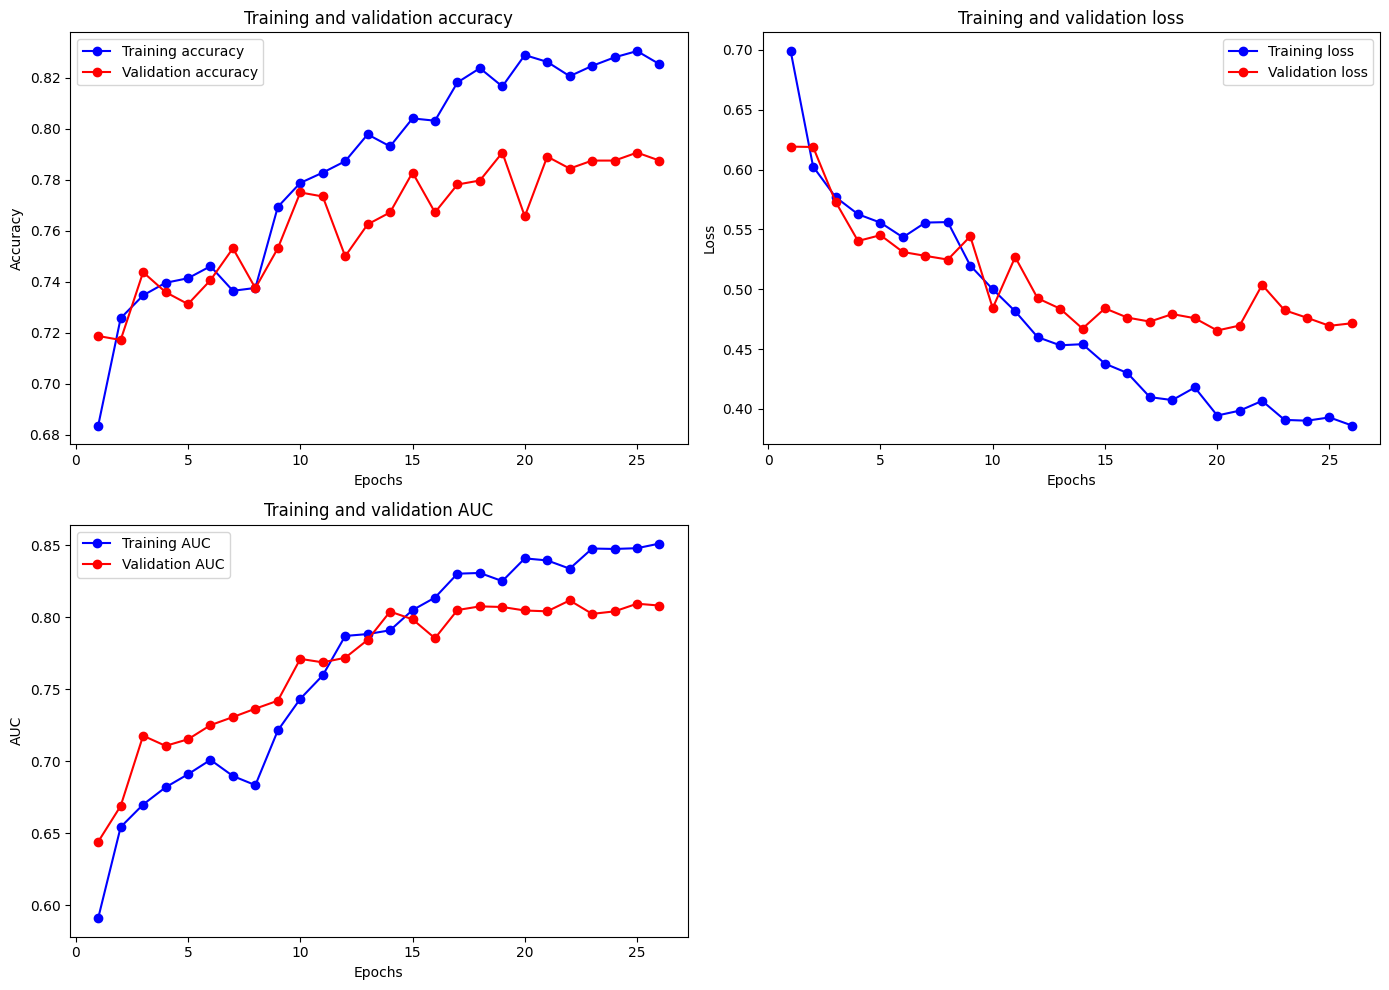

Overall Accuracy: 0.7900523560209424
Overall AUC: 0.802983615981604
Overall Sensitivity: 0.46122448979591835
Overall Specificity: 0.9035211267605634
Overall Data Length: 1910


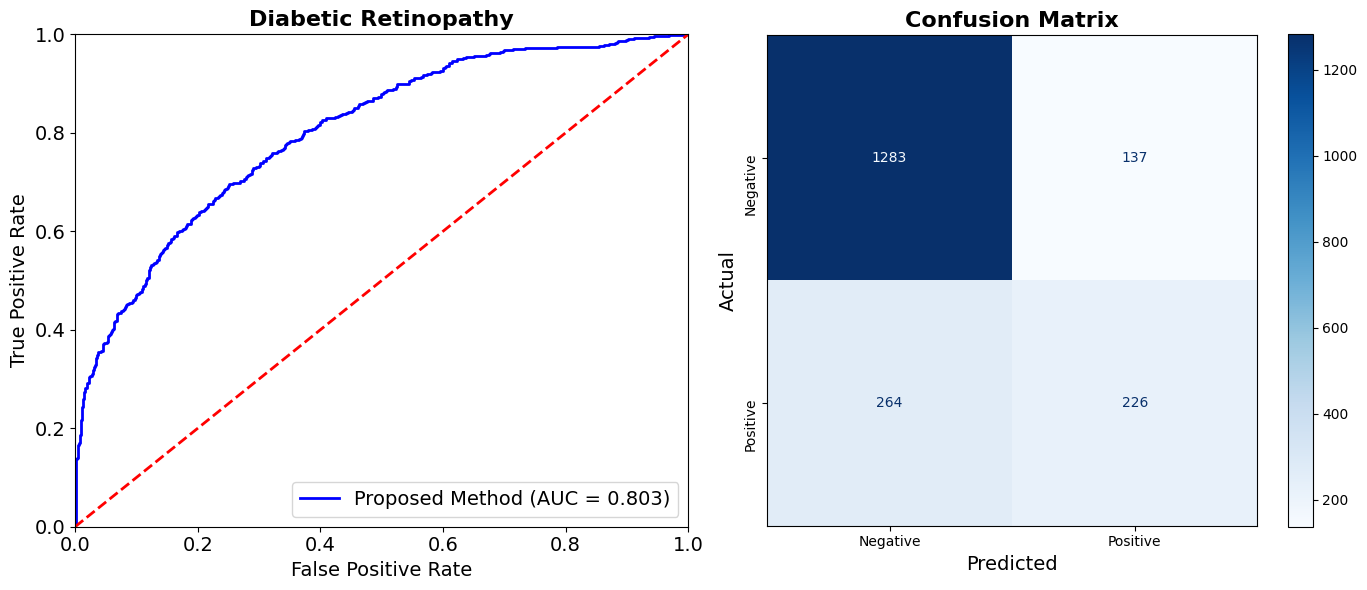

Male Accuracy: 0.7691561590688651
Male AUC: 0.8101554993430985
Male Sensitivity: 0.43820224719101125
Male Specificity: 0.8848167539267016
Male Data Length: 1031


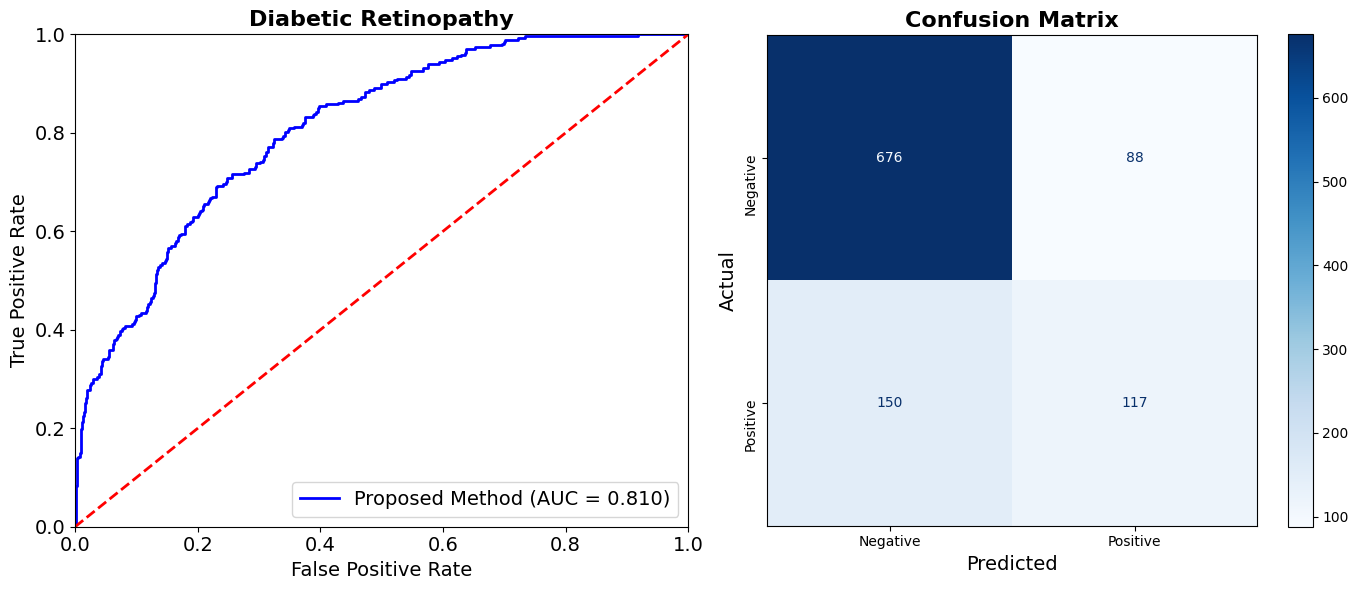

Female Accuracy: 0.8145620022753128
Female AUC: 0.7942756753800722
Female Sensitivity: 0.48878923766816146
Female Specificity: 0.9253048780487805
Female Data Length: 879


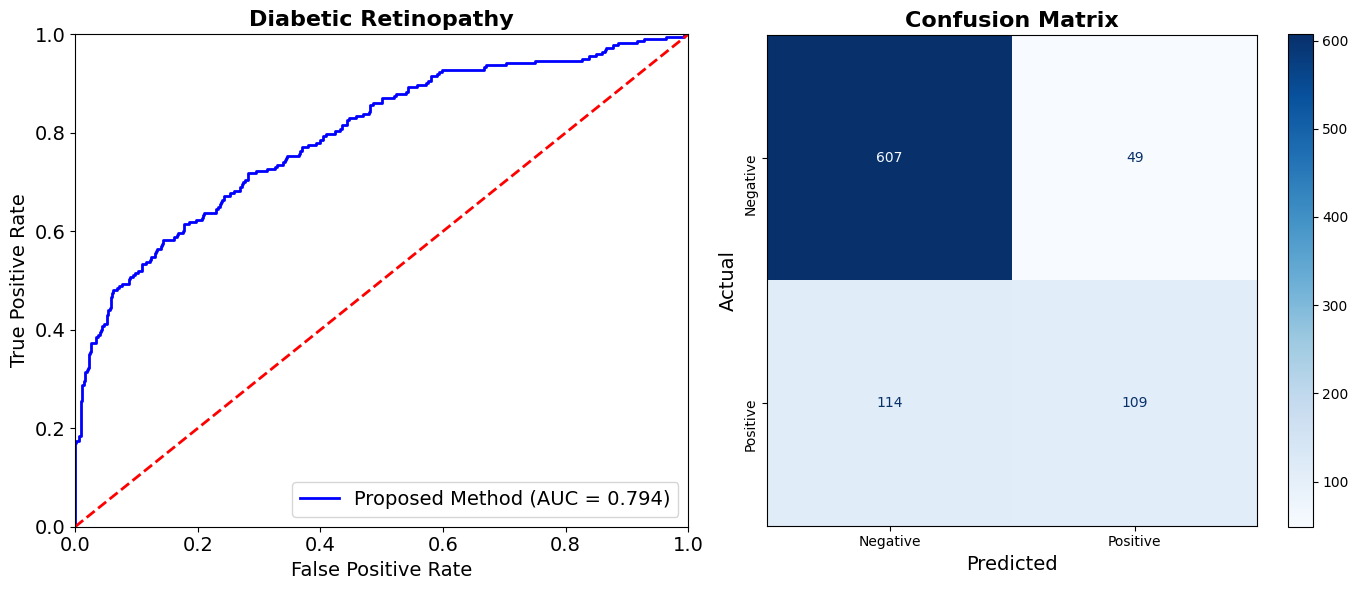

In [124]:
best_model_path = 'models\\cnn_model_0.790acc_0.803auc_12-03'
best_model = tf.keras.models.load_model(f'{best_model_path}.h5')
best_model_details = np.load(f'{best_model_path}.npz', allow_pickle=True)

best_model_test_data = best_model_details['test_data'].tolist()
best_model_history = best_model_details['history'].tolist()
best_model_params = best_model_details['params'].tolist()

print("Best Model Parameters: ", best_model_params)
plot_model_history(best_model_history)
_, _, _ = evaluate_model(best_model, test_generator, test_data=best_model_test_data, subgroup_analysis=True)

#
## Vision Transformer Model Training

In [ ]:
train_generator = DataGenerator(ftrain, shape=(224, 224, 3), batch_size=10, shuffle=True, clahe=True, augment=True, use_vit=True)
validation_generator = DataGenerator(fval, shape=(224, 224, 3), batch_size=10, clahe=True, use_vit=True)
test_generator = DataGenerator(ftest, shape=(224, 224, 3), batch_size=10, clahe=True, use_vit=True)


def build_vit_model(num_classes=1, dropout=0.2):
    base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    base_model.vit.pooler.trainable = False
    base_model.vit.layernorm.trainable = False
    for i in range(12):
        base_model.vit.encoder.layer[i].intermediate.trainable = False
        base_model.vit.encoder.layer[i].layernorm_before.trainable = False
        base_model.vit.encoder.layer[i].layernorm_after.trainable = False

    # inputs
    pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')
    
    # model layers
    vit = base_model.vit(pixel_values, training=True).last_hidden_state
    x = tf.keras.layers.Dropout(dropout)(vit[:, 0, :])
    classifier = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='outputs')(x)
    
    model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

    return model

vit_model = build_vit_model(dropout=0.5)

vit_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['acc', 'AUC']
)

vit_model.summary()

history = vit_model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 10,
    verbose = 1,
    validation_data = validation_generator,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
    ]
)

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pixel_values (InputLayer)   [(None, 3, 224, 224)]     0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem_1  (None, 768)               0         
  (SlicingOpLambda)                                              
                                                           

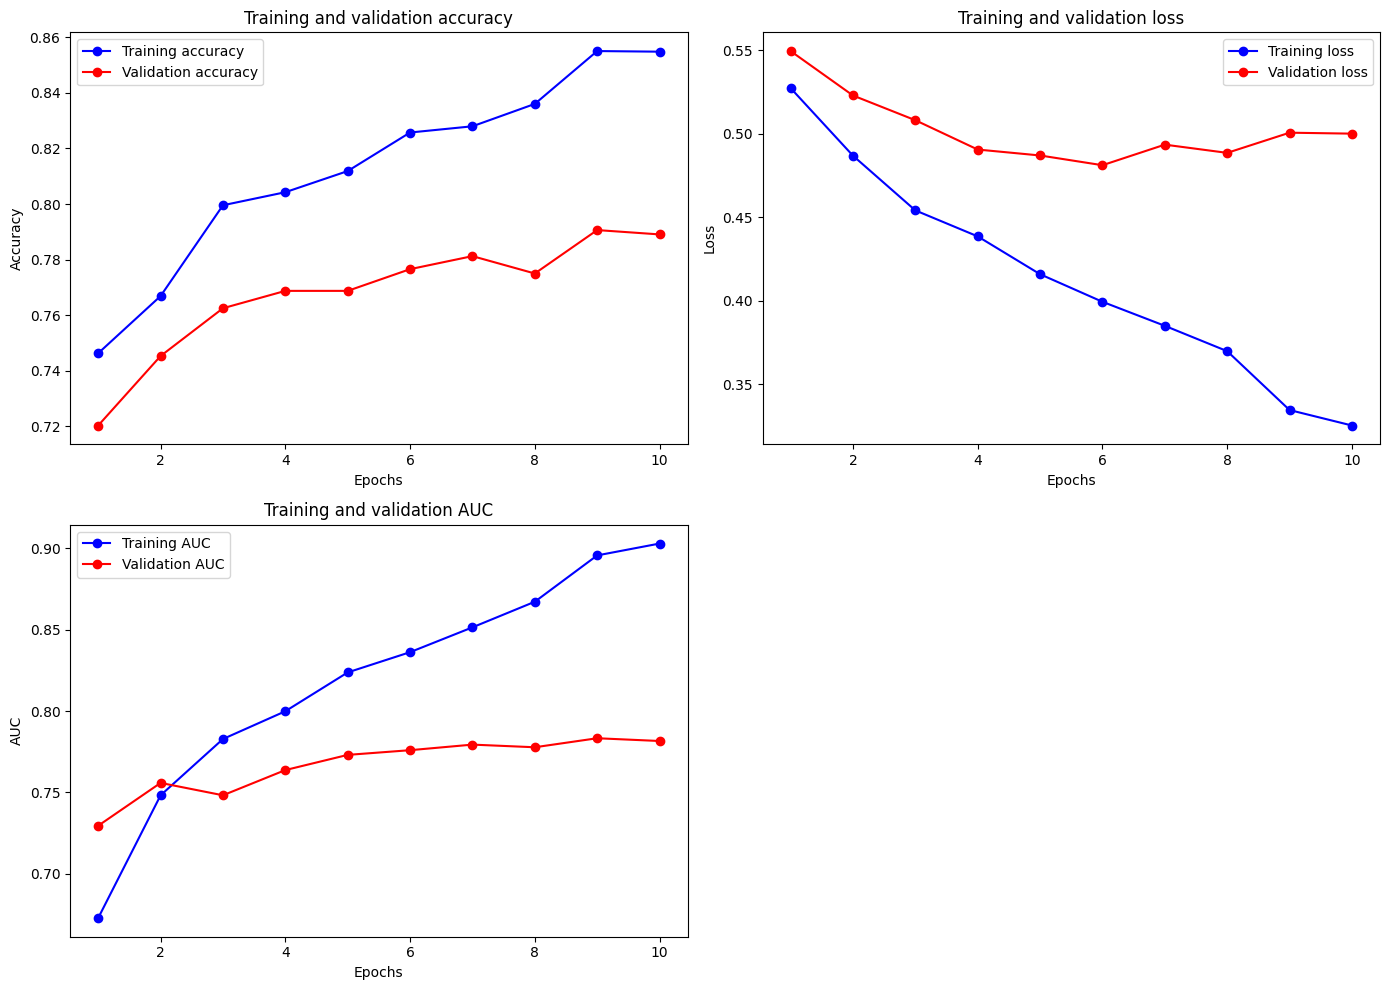

Overall Accuracy: 0.7952879581151833
Overall AUC: 0.7792354124748492
Overall Sensitivity: 0.29591836734693877
Overall Specificity: 0.967605633802817
Overall Data Length: 1910


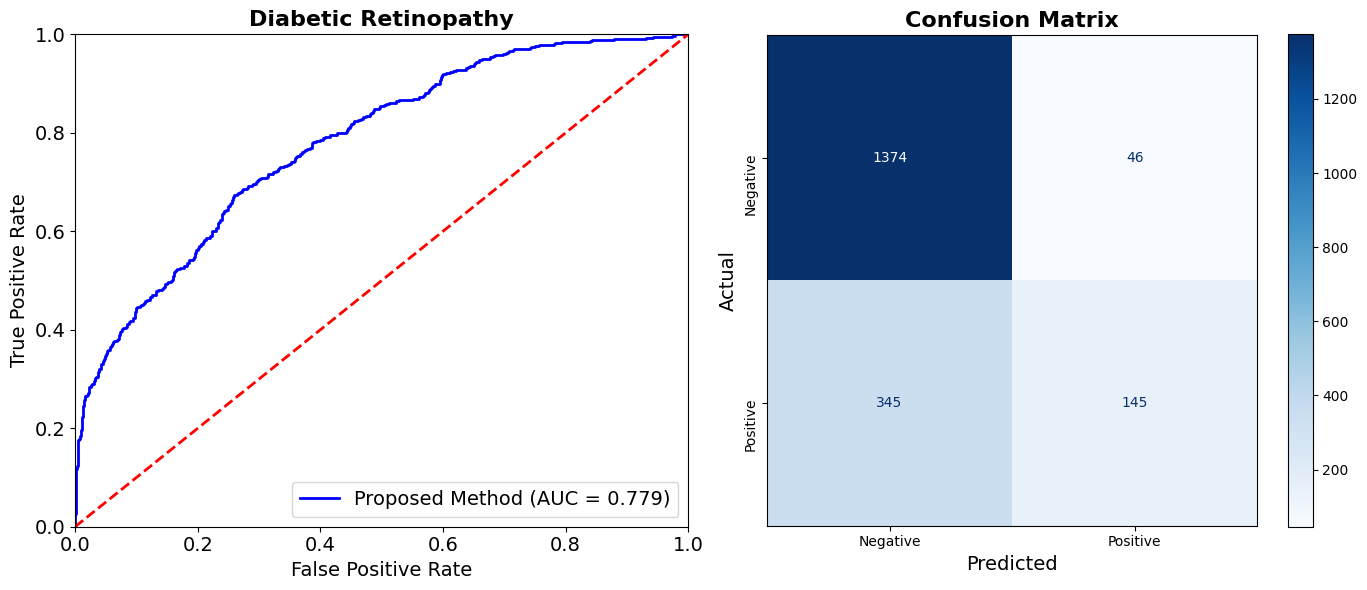

Male Accuracy: 0.7873786407766991
Male AUC: 0.7764835240353228
Male Sensitivity: 0.2883895131086142
Male Specificity: 0.9619921363040629
Male Data Length: 1030


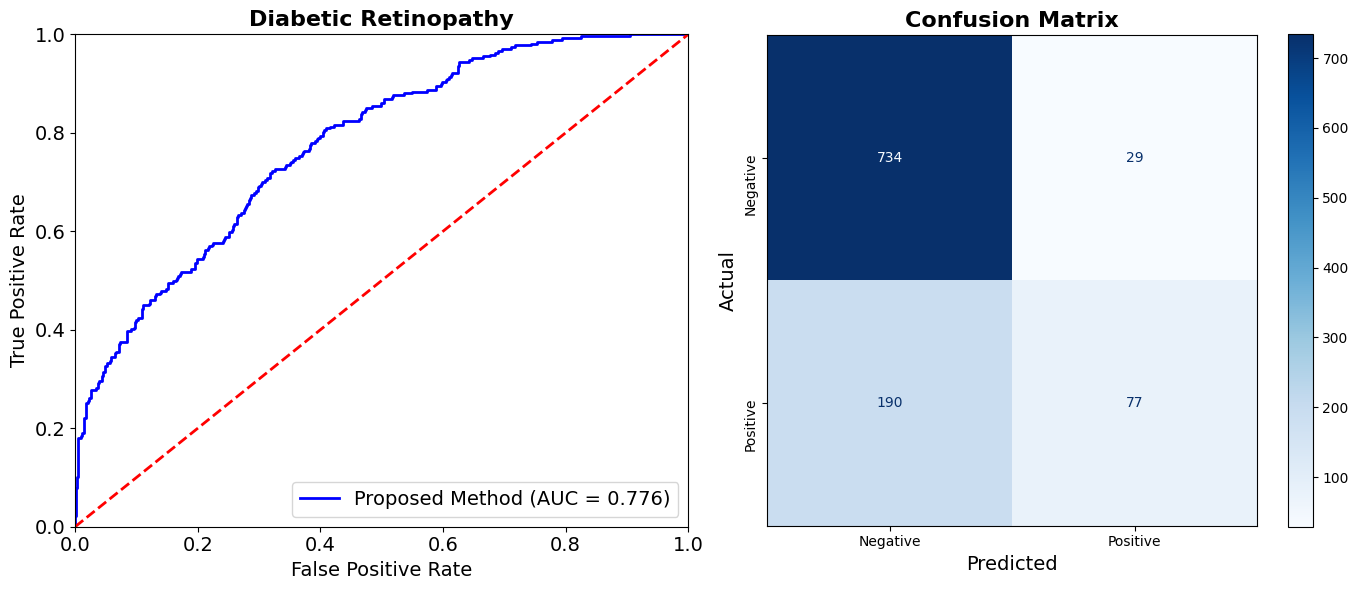

Female Accuracy: 0.8045454545454546
Female AUC: 0.7816068418070998
Female Sensitivity: 0.30493273542600896
Female Specificity: 0.974124809741248
Female Data Length: 880


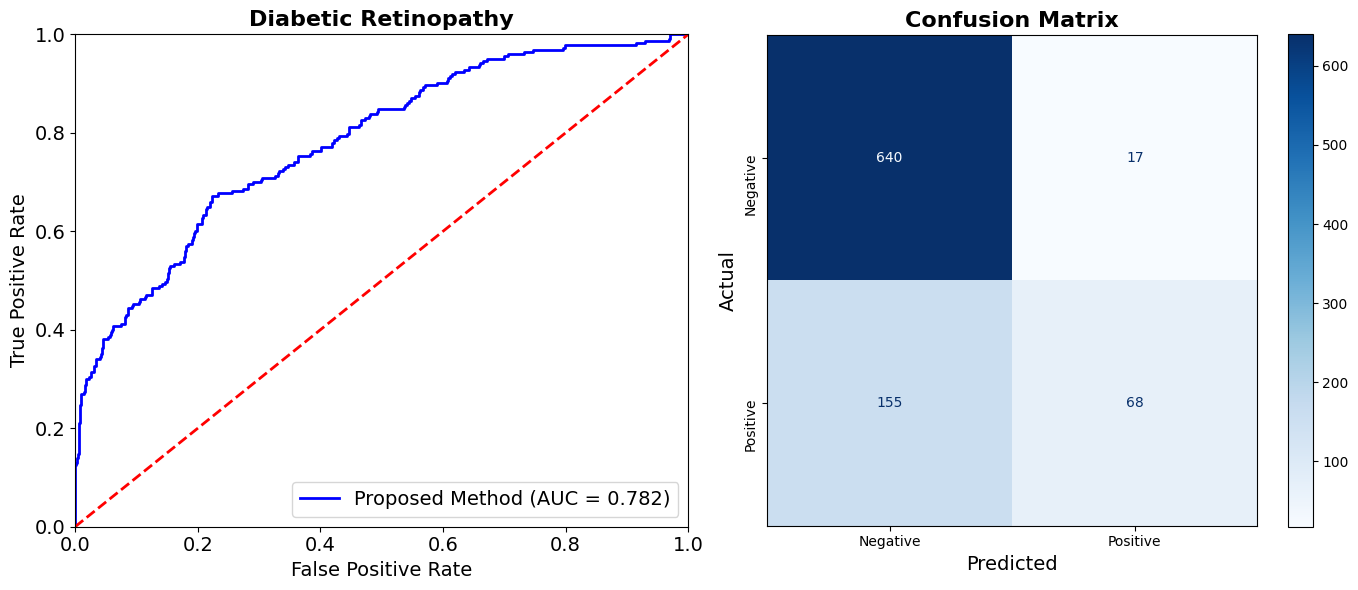

In [85]:
plot_model_history(history.history)
test_auc, test_acc, test_data = evaluate_model(vit_model, test_generator)

In [ ]:
PARAMS = {
    'dropout': 0.5,
    'learning_rate': 1e-5,
    'batch_size': 10,
    'use_clahe': True,
    'gauss_filter': False,
    'classifier_activation': 'sigmoid',
    'minority_weight': None
}

save_model(vit_model, test_data, test_acc, test_auc, history, PARAMS , 'vit')

c:\Users\caleb\miniconda3\envs\tf\lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully saved as cnn_model_0.795acc_0.779auc_12-02


In [ ]:
best_model_path = 'models\\vit_model_0.795acc_0.779auc_12-02'
best_model = tf.keras.models.load_model(f'{best_model_path}.h5')
best_model_details = np.load(f'{best_model_path}.npz', allow_pickle=True)

best_model_test_data = best_model_details['test_data'].tolist()
best_model_history = best_model_details['history'].tolist()
best_model_params = best_model_details['params'].tolist()

plot_model_history(best_model_history)
evaluate_model(best_model, test_generator, test_data=best_model_test_data, subgroup_analysis=True)